In [1]:
import numpy as np
from numpy.random import default_rng
from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, NamedTuple, Optional

In [2]:
class PVTrainDataSet(NamedTuple):
    treatment: np.ndarray
    treatment_proxy: np.ndarray
    outcome_proxy: np.ndarray
    outcome: np.ndarray
        
class PVTestDataSet(NamedTuple):
    treatment: np.ndarray
    structural: np.ndarray

In [44]:
def generatate_synth_core(n_sample: int, rng, sigma: float = np.sqrt(3), beta: float = np.sqrt(0.05)):
    U2 = rng.uniform(-1, 2, n_sample)
    U1 = rng.uniform(0, 1, n_sample) - ((U2 > 0) & (U2 < 1)).astype(int)
    W1 = U1 + rng.uniform(-1, 1, n_sample)
    W2 = U2 + rng.normal(0, sigma, n_sample)
    Z1 = U1 + rng.normal(0, sigma, n_sample)
    Z2 = U2 + rng.uniform(-1, 1, n_sample)
    A = U2 + rng.normal(0, beta, n_sample)
    Y = U2 * np.cos(2 * (A + 0.3 * U1 + 0.2)) 
    return U1, U2, Z1, Z2, A, W1, W2, Y

def generate_train_synth(n_sample: int, sigma: float = np.sqrt(3), beta: float = np.sqrt(0.05),
                             seed=42, **kwargs):
    rng = default_rng(seed=seed)
    U1, U2, Z1, Z2, A, W1, W2, Y = generatate_synth_core(n_sample, rng, sigma, beta)
    return PVTrainDataSet(treatment=A[:, np.newaxis],
                          treatment_proxy=np.c_[Z1, Z2],
                          outcome_proxy=np.c_[W1, W2],
                          outcome=Y[:, np.newaxis]
                         )

def cal_outcome(A, U1, U2):
    Y = U2 * np.cos(2 * (A + 0.3 * U1 + 0.2))
    return Y


def cal_structural(a: float):
    rng = default_rng(seed=42)
    # U1, U2, Y
    U2 = rng.uniform(-1, 2, n_sample)
    U1 = rng.uniform(0, 1, n_sample) - ((U2 > 0) & (U2 < 1)).astype(int)
    outcome = cal_outcome(a, U1, U2)
    # for each A=a average over U1 & U2 to get Y_A = Y_a
    return np.mean(outcome)


def generate_test_synth(a_start: float = -2, a_end: float = 2, n_steps: int = 1000):
    a_steps = np.linspace(a_start, a_end, n_steps)
    struc = np.array([cal_structural(a) for a in a_steps])
    return PVTestDataSet(treatment=a_steps[:, np.newaxis],
                         structural=struc[:, np.newaxis],
                         )

In [89]:
n_sample = 1000
random_seed = 100

In [90]:
first_stage_train_data_org = generate_train_synth(n_sample=n_sample, seed=random_seed)
second_stage_train_data_org = generate_train_synth(n_sample=n_sample, seed=random_seed + 2)
val_data_org = generate_train_synth(n_sample=n_sample, seed=random_seed + 1) # for outcome validation
test_data_org = generate_test_synth()

In [91]:
# train 2SLS model (from Miao et al.)
first_stage_model1 = linear_model.LinearRegression()  # W1 ~ A + Z1 + Z2
first_stage_model2 = linear_model.LinearRegression()  # W2 ~ A + Z1 + Z2
second_stage_model = linear_model.LinearRegression()  # Y ~ A + \hat{W}_1 + \hat{W}_2

In [92]:
# W1, W2
first_stage_W1 = first_stage_train_data_org.outcome_proxy[:, 0].reshape(-1, 1)
first_stage_W2 = first_stage_train_data_org.outcome_proxy[:, 1].reshape(-1, 1)
# A, Z1, Z2
first_stage_features = np.concatenate((first_stage_train_data_org.treatment, first_stage_train_data_org.treatment_proxy), axis=1)
# fit first model1: W1 ~ A + Z1 + Z2
first_stage_model1.fit(first_stage_features, first_stage_W1)
# fit first model2: W2 ~ A + Z1 + Z2
first_stage_model2.fit(first_stage_features, first_stage_W2)
# \hat{W} predicted
W_hat1 = first_stage_model1.predict(
    np.concatenate((second_stage_train_data_org.treatment, second_stage_train_data_org.treatment_proxy), axis=1))
W_hat2 = first_stage_model2.predict(
    np.concatenate((second_stage_train_data_org.treatment, second_stage_train_data_org.treatment_proxy), axis=1))
# \hat{W} combined
W_hat = np.concatenate((W_hat1, W_hat2), axis=1)
# fit second model: Y ~ A + \hat{W}
second_stage_model.fit(np.concatenate((second_stage_train_data_org.treatment, W_hat), axis=1),
                       second_stage_train_data_org.outcome.reshape(-1, 1))

LinearRegression()

In [93]:
# problem specifc dimension stuff to create evaluation set
intervention_array_len = test_data_org.treatment.shape[0]
num_val_samples = val_data_org.treatment.shape[0]
a = test_data_org.treatment
temp_A = np.broadcast_to(a,(a.shape[0], num_val_samples))
w1 = val_data_org.outcome_proxy[:, 0].reshape(-1, 1)
w2 = val_data_org.outcome_proxy[:, 1].reshape(-1, 1)
temp_W1 = np.broadcast_to(w1,(w1.shape[0], intervention_array_len))
temp_W2 = np.broadcast_to(w2,(w2.shape[0], intervention_array_len))
AW_test = np.stack((temp_A, temp_W1.T, temp_W2.T), axis=-1) #evaluation set for Y
AW_test.shape

(1000, 1000, 3)

In [94]:
# we train the model on (A, \hat{W}), but evaluate it on (A, W) on test/outcome set?
pred = [np.mean(second_stage_model.predict(AW_test[i, :, :])) for i in range(AW_test.shape[0])]
mse_loss: float = np.mean((pred - test_data_org.structural.squeeze()) ** 2)
mae_loss: float = np.mean(np.abs(pred - test_data_org.structural.squeeze()))
mse_loss, mae_loss

(0.24162852966671344, 0.3871293212438605)

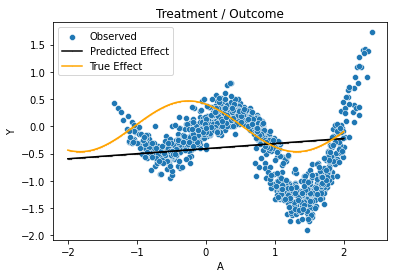

In [97]:
A = np.squeeze(first_stage_train_data_org.treatment)
Y = np.squeeze(first_stage_train_data_org.outcome)
y_pred = np.array(pred)
a_treat = np.squeeze(a)
y_true = test_data_org.structural.squeeze()
sns.scatterplot(x=A, y=Y, label='Observed')
plt.plot(a_treat, y_pred, color='black', marker='o', label="Predicted Effect", markersize=0.1)
plt.plot(a_treat, y_true, color='orange', marker='o', label="True Effect", markersize=0.1)
plt.title('Treatment / Outcome')
plt.xlabel('A')
plt.ylabel('Y')
plt.legend()
plt.show()

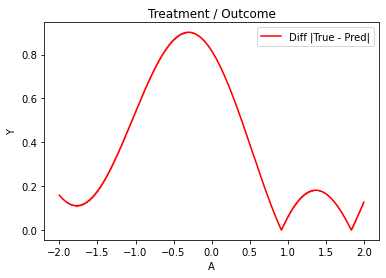

In [96]:
plt.plot(a_treat, np.abs(y_true - y_pred), color='red', marker='o', label="Diff |True - Pred|", markersize=0.1)
plt.title('Treatment / Outcome')
plt.xlabel('A')
plt.ylabel('Y')
plt.legend()
plt.show() #range of Mastouri models are from 0 to 1.5